https://www.kaggle.com/datatattle/covid-19-nlp-text-classification || Here is the link

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stopWords = set(stopwords.words('english'))

In [125]:
data = pd.read_csv('/content/sample_data/Corona_NLP_train.csv',encoding='latin-1')

In [126]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [127]:
data = data.drop(['UserName','ScreenName','TweetAt','Location'],axis=1)

In [128]:
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [130]:
data.shape #3000+ data looks good

(41157, 2)

In [131]:
print(data.Sentiment.unique())
print(len(data.Sentiment.unique()))

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
5


In [132]:
MappedSentiment = {k:i for i,k in enumerate(data.Sentiment.unique())} # mapping label into integer

In [133]:
MappedSentiment # print the mapped label

{'Extremely Negative': 2,
 'Extremely Positive': 4,
 'Negative': 3,
 'Neutral': 0,
 'Positive': 1}

In [134]:
data.Sentiment = data.Sentiment.map({'Extremely Positive':'Positive',
                                     'Extremely Negative':'Negative',
                                     'Negative':'Negative',
                                     'Positive':'Positive',
                                     'Neutral':'Neutral'}) # lets make it to 3 class only

In [135]:
data.Sentiment = data.Sentiment.map(MappedSentiment)

In [136]:
data.head(1) #looks good for sentiment

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0


In [15]:
data.Sentiment.value_counts() #it looks balanced(?)

1    18046
3    15398
0     7713
Name: Sentiment, dtype: int64

In [16]:
data.iloc[4]['OriginalTweet'] # we need clean it before , it's a dirty data

"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n"

In [17]:
class Cleaning():
  def __init__(self,dataFrame):
    data=dataFrame.copy()
    data['Clean'] = self.lowerCase(data['OriginalTweet'])
    data = self.CleaningByRegex(data)
    self.data = data

  def lowerCase(self,dataFrame):
    return dataFrame.str.lower()

  def getData(self):
    return self.data

  def CleaningByRegex(self,data):
    data.Clean = data.Clean.replace(re.compile(r"(https\S+)")," ") #delete links
    data.Clean = data.Clean.replace(re.compile(r"(#\S+)")," ") #delete tag
    data.Clean = data.Clean.replace(re.compile(r"(@\S+)")," ") #delete tag
    data.Clean = data.Clean.replace(re.compile(r"[\W_]+")," ") # keeps only words
    return data

In [18]:
cleaningText = Cleaning(data)

In [19]:
cleaningText.getData().iloc[1]['OriginalTweet'] #before

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [20]:
cleaningText.getData().iloc[1]['Clean'] #after

'advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [21]:
dataClean = cleaningText.getData() #call the class

In [22]:
dataClean = dataClean.dropna().reset_index(drop=True) #drop the row where the clean data is empty

In [23]:
max_features = 10000
sequence_length = 40

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [24]:
vectorize_layer.adapt(dataClean['Clean'])

In [25]:
vectorize_layer(dataClean.iloc[25]['Clean']) #text to number, same like tokenizer

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([ 272, 3125, 6276,    2, 1872,  774,  182,    3,  194,  208,  623,
        434,   18,  623,  263,   23,  774,   17,    3,  287,   18,    2,
        245,  127,  258, 1625,    5,    2,   81,   39,  722, 3031,   92,
          0,    0,    0,    0,    0,    0,    0])>

In [27]:
X= dataClean.Clean.map(vectorize_layer)

In [38]:
XData = np.zeros((X.shape[0],sequence_length),dtype=int)

In [39]:
for i,j in enumerate(X):
  if X.values[i].numpy().shape[0]!=0:
    XData[i] = X.values[i].numpy()

In [40]:
XData

array([[   4,    4,    0, ...,    0,    0,    0],
       [ 512,  880,    3, ...,  239,    0,    0],
       [  81,  954, 4427, ...,    0,    0,    0],
       ...,
       [  14,  131,  196, ...,    0,    0,    0],
       [   9,   25,  709, ...,    0,    0,    0],
       [ 200,   95,  470, ...,   25,   16,  105]])

In [41]:
dataClean.head(1)

,OriginalTweet,Sentiment,Clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,and and


In [43]:
y = pd.get_dummies(dataClean.Sentiment)

In [44]:
y.head(1)

,0,1,3
0,1,0,0


In [45]:
from sklearn.model_selection import train_test_split

In [48]:
X_latih,X_test,Y_latih,Y_test = train_test_split(XData,y,test_size=0.2,random_state=40)

In [49]:
Y_test.head(1)

,0,1,3
2603,0,0,1


In [50]:
X_latih

array([[ 174,   14,   31, ...,    0,    0,    0],
       [   1,  356,    8, ...,  102,    2,  139],
       [  17,  833, 1597, ...,    3, 3997,  560],
       ...,
       [ 120,  231,   11, ...,    0,    0,    0],
       [  63,   11,    2, ...,    0,    0,    0],
       [  13,  234,    3, ...,   13,  150,   60]])

In [51]:
X_test

array([[  13, 8490,    2, ...,   51,   13,  150],
       [ 585,   12,   10, ...,   37, 8275,  445],
       [1339, 2623,   17, ...,    0,    0,    0],
       ...,
       [  54,  632,   38, ...,  148,  553, 1000],
       [ 490,   15,  834, ...,    0,    0,    0],
       [6322, 1381, 6153, ...,   15,   80,   59]])

In [59]:
def buildModel():
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features ,output_dim=50,input_length=sequence_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(20, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
  return model

In [60]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [61]:
model = buildModel()

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 50)            500000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 63        
                                                                 
Total params: 530,803
Trainable params: 530,803
Non-trainable params: 0
_________________________________________________________________


In [63]:
earlyCallback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [64]:
num_epochs = 1000
history = model.fit(X_latih, Y_latih, batch_size=100,epochs=num_epochs,verbose=1,
                    callbacks=[callbacks,earlyCallback],validation_data=(X_test, Y_test))

Epoch 1/1000
330/330 [==============================] - 23s 62ms/step - loss: 0.8442 - accuracy: 0.6009 - val_loss: 0.5410 - val_accuracy: 0.8038
Epoch 2/1000
330/330 [==============================] - 20s 59ms/step - loss: 0.4667 - accuracy: 0.8515 - val_loss: 0.4356 - val_accuracy: 0.8541
Epoch 3/1000
330/330 [==============================] - 20s 59ms/step - loss: 0.3400 - accuracy: 0.8945 - val_loss: 0.3991 - val_accuracy: 0.8684
Epoch 4/1000
330/330 [==============================] - 20s 60ms/step - loss: 0.2739 - accuracy: 0.9121 - val_loss: 0.4355 - val_accuracy: 0.8642
Epoch 5/1000
330/330 [==============================] - 20s 60ms/step - loss: 0.2278 - accuracy: 0.9249 - val_loss: 0.5428 - val_accuracy: 0.8636
Epoch 6/1000
330/330 [==============================] - 20s 60ms/step - loss: 0.2017 - accuracy: 0.9311 - val_loss: 0.5410 - val_accuracy: 0.8558
Epoch 7/1000
330/330 [==============================] - 20s 60ms/step - loss: 0.1835 - accuracy: 0.9366 - val_loss: 0.6780 -

The val accuracy doesnt improve after 5 epochs and stopped by early callback ,i guess that's the best the algorithm can reach (after hyperparameter tuning the accuracy finally reach 85%)

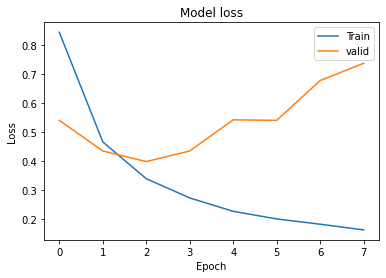

In [173]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','valid'], loc='upper right')
plt.show()

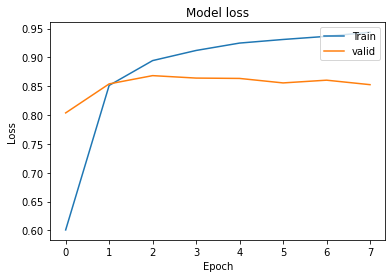

In [172]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','valid'], loc='upper right')
plt.show()

looks kinda overfitting, but it's not pretty far so i guess it's fine

Test data

In [137]:
dataTes = pd.read_csv('/content/sample_data/Corona_NLP_test.csv',encoding='latin-1')

In [138]:
dataTes.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [139]:
dataTes = dataTes.drop(['UserName','ScreenName','TweetAt','Location'],axis=1)

In [140]:
dataTes.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [141]:
dataTes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3798 non-null   object
 1   Sentiment      3798 non-null   object
dtypes: object(2)
memory usage: 59.5+ KB


In [142]:
dataTes.shape #3000+ 

(3798, 2)

In [143]:
dataTes.Sentiment = dataTes.Sentiment.map({'Extremely Positive':'Positive',
                                     'Extremely Negative':'Negative',
                                     'Negative':'Negative',
                                     'Positive':'Positive',
                                     'Neutral':'Neutral'}) # lets make it to 3 class only

In [144]:
dataTes.Sentiment = dataTes.Sentiment.map(MappedSentiment)

In [145]:
dataTes.head(1) #looks good for sentiment

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,3


In [146]:
dataTes.Sentiment.value_counts() #it looks balanced(?)

3    1633
1    1546
0     619
Name: Sentiment, dtype: int64

In [147]:
cleaningTestData = Cleaning(dataTes)

In [148]:
dataTestClean = cleaningTestData.getData()

In [160]:
XTes= dataTestClean.Clean.map(vectorize_layer)

In [161]:
XDataTes = np.zeros((XTes.shape[0],sequence_length),dtype=int)

In [162]:
for i,j in enumerate(XTes):
  if XTes.values[i].numpy().shape[0]!=0:
    XDataTes[i] = XTes.values[i].numpy()

In [163]:
yTes = pd.get_dummies(dataTestClean.Sentiment)

In [164]:
yTes.head(1)

,0,1,3
0,0,0,1


In [165]:
XDataTes

array([[2843,   95, 5162, ...,    0,    0,    0],
       [  78,   13, 1617, ...,    0,    0,    0],
       [ 205,   45,   54, ...,    0,    0,    0],
       ...,
       [   1, 4641,    5, ...,    0,    0,    0],
       [ 857,   64,    3, ...,    0,    0,    0],
       [  13,    4,  799, ...,    0,    0,    0]])

In [167]:
model.evaluate(XDataTes,yTes,verbose=1)

119/119 [==============================] - 1s 11ms/step - loss: 0.7796 - accuracy: 0.8454


[0.7796187996864319, 0.8454449772834778]

Looks the data has been generalized by the model

in this code i use 3 set of data that are train data for training, validation data for validation in neural network and the last test data for testing


in train data i get accuracy value of 94.37%
in validation data i get accuracy value of 85.28%
in test data i get accuracy value of 84.5%

so basically i can say my model has generalized the data
because the difference of accuracy between validation and test data quite small
#CMIIW